<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysis pipeline summary: Compute SacreBleu score. This also gives us all the reference and translation sentences. Parse the file created by sacreBleu to get 3 files: 1 file with references, 1 with the corresponding translations and 1 with the avg, min, median, max logprob scores of all the tokens for each sentence. The we run fairseq-score to get BLEU score for each sentence. 

In [0]:
pip install fairseq sacrebleu sentencepiece

     |████████████████████████████████| 307kB 17.5MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 1.0MB 44.4MB/s 
     |████████████████████████████████| 17.1MB 211kB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2033613 sha256=d5e4d9bde2c982f46fce55d8541277148ac8f9a500e4d8824461801a93fbdfdd
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
 analysis	   data-bin		        LM_Thresholding.ipynb
 Analysis	   Ensembles		        NCD_Analysis.ipynb
 backward_models   Ensembling		        noisychannel
 checkpoints	   FLORES.ipynb		        NoisyChannel.ipynb
 configs	   language_models	        Resources
 data		  'LM_Thresholding (1).ipynb'   scripts
/content/drive/My Drive/ConfidentMachineTranslation/flores


Compute BLEU score using sacrebleu

In [0]:
!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang ne --target-lang en \
    --path Ensembles/April_04.pt \
    --beam 5 --lenpen 1.2 \
    --gen-subset test \
    --remove-bpe=sentencepiece \
    --sacrebleu > analysis/testSet_BLEU.txt

  0% 0/14 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
# !fairseq-generate \
#     data-bin/wiki_ne_en_bpe5000/ \
#     --source-lang en --target-lang ne \
#     --path backward_models/April_17.pt \
#     --beam 5 --lenpen 1.2 \
#     --gen-subset test \
#     --remove-bpe=sentencepiece \
#     --sacrebleu
    # --sacrebleu > analysis/testSet_BLEU.txt

The code below first parses the result from fairseq-generate, then puts it in two different files and then finally gets the sentence level bleu scores!

In [0]:
from statistics import mean, median 

bleu_res = open("analysis/testSet_BLEU.txt", "r")
NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "w")
NMT_output = open("analysis/translated_sentences.txt", "w")
Sentence_stats = open("analysis/logprob_statistics.txt", "w")

for line in bleu_res:
    if line.startswith("H-"):
        NMT_output.write(line.split("	")[2])
    elif line.startswith("T-"):
        NMT_ground_truth.write(line.split("	")[1])
    elif line.startswith("P-"):
        scores = [float(i) for i in line.split("\t")[1].split(" ")]
        Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+"\n")

NMT_ground_truth.close()
NMT_output.close()
Sentence_stats.close()

We now use the two files produced to find sentence level bleu scores

In [0]:
!fairseq-score --sys analysis/translated_sentences.txt --ref analysis/ground_truth_sentences.txt --sentence-bleu > analysis/scores.txt

BASELINE

The next segment uses the sentence level bleu scores produced above along with the input and translated sentence pairs to calculate the fraction of datasets which lies above a specific threshold. We use the sorted list of BLEU scores for all sentences as thresholds. 

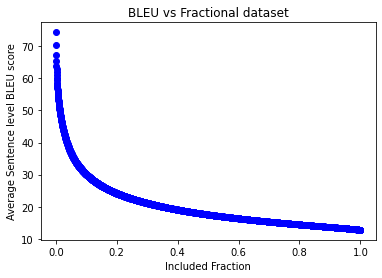

AUC for incuded fraction: 20.175513054960824


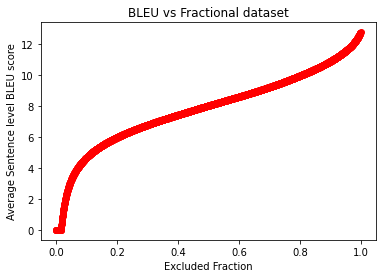

AUC for excluded fraction: 7.805317512946668


In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc

class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    included_sum = 0
    excluded_sum = 0

    for index in range(0, len(translations)):
        if index < split_index:
            excluded_sum += translations[index].score
        else:
            included_sum += translations[index].score
    included_score = 0 if split_index == len(translations) - 1 else included_sum/(len(translations) - split_index)
    excluded_score = 0 if split_index == 0 else excluded_sum/(split_index)
    return excluded_score, included_score

NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")

files = [NMT_ground_truth, NMT_output, Sentence_bleu]
next(Sentence_bleu)
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, score = lines
    score = float(score.split("BLEU4 = ")[1].split(",")[0])
    translations.append(Translation(reference, translation, score))

translations.sort(key=lambda x: x.score, reverse=False)

inclusion_scores = []
exclusion_scores = []
fraction_included = []
fraction_excluded = []

include_graph = True

for split_index in range(0, len(translations)-1):
    # if (translations[split_index].score == 0.0):
    #     print(translations[split_index].reference)
    #     print(translations[split_index].translation)
    exclusion, inclusion = compute_excluded_included_score(translations, split_index)
    inclusion_scores.append(inclusion)
    exclusion_scores.append(exclusion)
    fraction_included.append((len(translations) - split_index)/len(translations))
    fraction_excluded.append(split_index/len(translations))

  
plt.scatter(fraction_included, inclusion_scores, color= "blue")
plt.xlabel('Included Fraction') 
plt.ylabel('Average Sentence level BLEU score') 
plt.title('BLEU vs Fractional dataset') 
plt.show() 

print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))

plt.scatter(fraction_excluded, exclusion_scores, color= "red")
plt.xlabel('Excluded Fraction') 
plt.ylabel('Average Sentence level BLEU score') 
plt.title('BLEU vs Fractional dataset') 
plt.show()  

print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))

NMT_ground_truth.close()
NMT_output.close()
Sentence_bleu.close()

We now use (average/max/min/median) logprob token score for each sentence for thresholding and get BLEU (corpus) vs Fractional dataset graphs. 

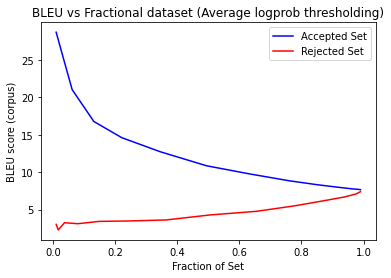

AUC for incuded fraction: 11.962271604938271
AUC for excluded fraction: 4.3989259259259255


KeyboardInterrupt: ignored

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from numpy import arange
import subprocess
import random
import numpy as np


class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

    for i in range(len(translations)):
        if i < split_index:
            temporary_reference_exclusion.write(translations[i].reference)
            temporary_output_exclusion.write(translations[i].translation)
        else:
            temporary_reference_inclusion.write(translations[i].reference)
            temporary_output_inclusion.write(translations[i].translation)

    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
    !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

    temporary_inclusion_result = open("analysis/inclusion_result.txt")
    temporary_exclusion_result = open("analysis/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_stats = open("analysis/logprob_statistics.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")

next(Sentence_bleu)
files = [NMT_ground_truth, NMT_output, Sentence_stats, Sentence_bleu]
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    stats.append(sentence_bleu)
    translations.append(Translation(reference, translation, stats))

stats_for_thresholding = [0,1,2,3,4] #average per token, min, median, max, sentence_bleu
num_to_thresh = {0:"Average logprob thresholding", 1: "Min logprob thresholding", 2:"Median logprob thresholding", 3:"Max logprob thresholding", 4:"Sentence-level BLEU thresholding"}
all_inclusion_scores = []
all_fractions_included = []

for stat in stats_for_thresholding:
    translations.sort(key=lambda x: x.score[stat], reverse=False)
    # print("Worst reference: " +translations[0].reference+" Worst translation: "+translations[0].translation)
    thresholds = []


    ##25 good thresholds for each case
    if stat == 0:
        thresholds = np.linspace(-1.5, 0, 25).tolist()
    elif stat == 1:
        thresholds = np.linspace(-3.5, 0, 25).tolist()
    elif stat == 2:
        thresholds = np.linspace(-1.5, 0, 25).tolist()
    elif stat == 3:
        thresholds = np.linspace(-0.1, 0, 25).tolist() 
    elif stat == 4:
        thresholds = np.linspace(0, 70, 25).tolist()

    inclusion_scores = []
    exclusion_scores = []
    fraction_included = []
    fraction_excluded = []

    for threshold in thresholds:
        split_index = 1 ## We always start at 1% so that the exclusion set is never empty. 
        while split_index < 0.99*len(translations) and translations[split_index].score[stat] < threshold:  ##0.99*len(translations) - to make sure the inclusion set always has a good number of examples
            split_index += 1
        exclusion, inclusion = compute_excluded_included_score(translations, split_index)
        inclusion_scores.append(inclusion)
        exclusion_scores.append(exclusion)
        fraction_included.append((len(translations) - split_index)/len(translations))
        fraction_excluded.append(split_index/len(translations))
    
    all_inclusion_scores.append(inclusion_scores)
    all_fractions_included.append(fraction_included)

    #########################   PLOTING   ################################
    # plt.xlabel('Fraction of Set') 
    # plt.ylabel('BLEU score (corpus)') 
    # plt.title('BLEU vs Fractional dataset ('+num_to_thresh[stat]+')') 
    
    # plt.plot(fraction_included, inclusion_scores, label = "Accepted Set", color= "blue")
    # plt.plot(fraction_excluded, exclusion_scores, label = "Rejected Set", color= "red")
    # plt.legend(loc="upper right")
    # plt.show() 


    # plt.xlabel('Fraction Below Threshold') 
    # plt.ylabel('BLEU score (corpus)') 
    # plt.title('BLEU vs Fractional dataset ('+num_to_thresh[stat]+')') 
    # plt.show()  
    print(num_to_thresh[stat])
    print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))
    print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))
    ####################################################################

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('Comparing thresholds') 
for i in range(len(all_inclusion_scores)):
    r = random.random()
    b = random.random()
    g = random.random()
    c = (r, g, b)
    plt.plot(all_fractions_included[i], all_inclusion_scores[i], label = num_to_thresh[i], color=c)

plt.legend(loc="upper right")
plt.show()

NMT_ground_truth.close()
NMT_output.close()
Sentence_bleu.close()

Histogram of sentence level Bleu

sanity check, sum of bars is:  1.0000000000000222


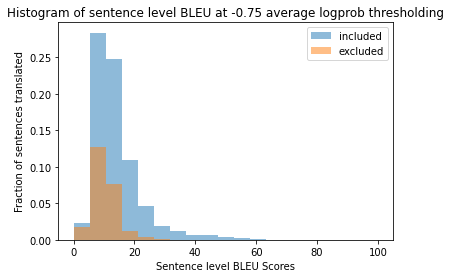

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, thresh):
    included = []
    excluded = []
    for index in range(0, len(translations)):
        if translations[index].score[0] >= thresh:
            included.append(translations[index].score[-1])
        else:
            excluded.append(translations[index].score[-1])
    return included, excluded

NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
NMT_output = open("analysis/translated_sentences.txt", "r")
Sentence_stats = open("analysis/logprob_statistics.txt", "r")
Sentence_bleu = open("analysis/scores.txt", "r")

files = [NMT_ground_truth, NMT_output, Sentence_stats, Sentence_bleu]
next(Sentence_bleu)
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    stats.append(sentence_bleu)
    translations.append(Translation(reference, translation, stats))

translations.sort(key=lambda x: x.score, reverse=False)

#Change this threshold to change thresholding variable
avgLogProbThresh = -0.75
bins = np.linspace(0, 100, 20)
included, excluded = compute_excluded_included_score(translations, avgLogProbThresh)

weights = np.ones_like(included)/len(translations)
vals1, _, _ = plt.hist(included, bins, alpha=0.5, label="included", weights=weights)
weights = np.ones_like(excluded)/len(translations)
vals2, _, _ = plt.hist(excluded, bins, alpha=0.5, label="excluded", weights=weights)
print("sanity check, sum of bars is: ", np.sum(vals1)+np.sum(vals2))
plt.ylabel("Fraction of sentences translated")
plt.xlabel("Sentence level BLEU Scores")
plt.legend(loc='upper right')
plt.title('Histogram of sentence level BLEU at -0.75 average logprob thresholding') 
plt.show()

NMT_ground_truth.close()
NMT_output.close()
Sentence_bleu.close()

Master script to run the whole thing for several models

['Ensembles/April_13.pt', 'Ensembles/April_14.pt']
Current model = Ensembles/April_13.pt
  0% 0/14 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
Average logprob thresholding
AUC for incuded fraction: 12.482858906525573
AUC for excluded fraction: 4.359354497354497
Min logprob thresholding
AUC for incuded fraction: 10.785888888888891
AUC for excluded fraction: 6.102273368606702
Median logprob thresholding
AUC for incuded fraction: 11.316509700176367
AUC for excluded fraction: 4.916774250440916
Max logprob thresholding
AUC for incuded fraction: 7.92814814814815
AUC for excluded fraction: 7.118973544973546
Sentence-level BLEU thresholding
AUC for incuded fraction: 16.662126984126985
AUC for excluded fraction: 2.375409171075838


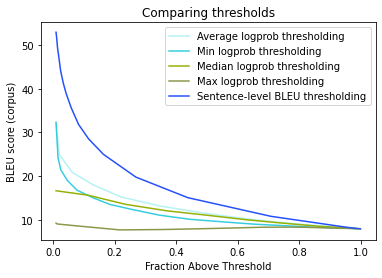

Current model = Ensembles/April_14.pt
  0% 0/14 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
Average logprob thresholding
AUC for incuded fraction: 12.585971781305116
AUC for excluded fraction: 4.1892310405643745
Min logprob thresholding
AUC for incuded fraction: 10.425261022927689
AUC for excluded fraction: 5.73431216931217
Median logprob thresholding
AUC for incuded fraction: 11.797366843033512
AUC for excluded fraction: 4.439178130511464
Max logprob thresholding
AUC for incuded fraction: 7.884774250440918
AUC for excluded fraction: 6.76720811287478
Sentence-level BLEU thresholding
AUC for incuded fraction: 16.40315343915344
AUC for excluded fraction: 2.3241269841269845


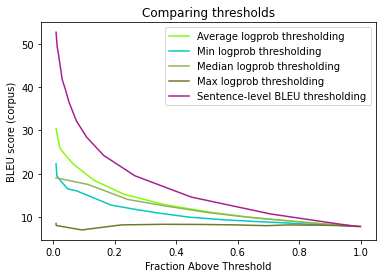

In [0]:
s# import glob
# path = 'Ensembles/*'
# ensemble_models = ""
# models = []
# for file in glob.glob(path):
#     models.append(file)

models = ['Ensembles/April_13.pt', 'Ensembles/April_14.pt']
print(models)

for model in models:

    print("Current model = " + model)

    !fairseq-generate \
        data-bin/wiki_ne_en_bpe5000/ \
        --source-lang ne --target-lang en \
        --path $model \
        --beam 5 --lenpen 1.2 \
        --gen-subset test \
        --remove-bpe=sentencepiece \
        --sacrebleu > analysis/testSet_BLEU.txt
    
    from statistics import mean, median 

    bleu_res = open("analysis/testSet_BLEU.txt", "r")
    NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "w")
    NMT_output = open("analysis/translated_sentences.txt", "w")
    Sentence_stats = open("analysis/logprob_statistics.txt", "w")

    for line in bleu_res:
        if line.startswith("H-"):
            NMT_output.write(line.split("	")[2])
        elif line.startswith("T-"):
            NMT_ground_truth.write(line.split("	")[1])
        elif line.startswith("P-"):
            scores = [float(i) for i in line.split("\t")[1].split(" ")]
            Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+"\n")

    NMT_ground_truth.close()
    NMT_output.close()
    Sentence_stats.close()

    !fairseq-score --sys analysis/translated_sentences.txt --ref analysis/ground_truth_sentences.txt --sentence-bleu > analysis/scores.txt

    from itertools import zip_longest
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc
    from numpy import arange
    import subprocess
    import random
    import numpy as np


    class Translation:
        def __init__ (self, ref, out, score):
            self.reference = ref
            self.translation = out
            self.score = score
        def __repr__(self):
            return str(self.score)

    def compute_excluded_included_score (translations, split_index):
        temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.txt", "w")
        temporary_output_inclusion = open("analysis/temporary_output_inclusion.txt", "w")

        temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.txt", "w")
        temporary_output_exclusion = open("analysis/temporary_output_exclusion.txt", "w")

        for i in range(len(translations)):
            if i < split_index:
                temporary_reference_exclusion.write(translations[i].reference)
                temporary_output_exclusion.write(translations[i].translation)
            else:
                temporary_reference_inclusion.write(translations[i].reference)
                temporary_output_inclusion.write(translations[i].translation)

        temporary_reference_inclusion.close()
        temporary_output_inclusion.close()
        temporary_reference_exclusion.close()
        temporary_output_exclusion.close()

        !fairseq-score --sys analysis/temporary_output_inclusion.txt --ref analysis/temporary_reference_inclusion.txt --sacrebleu > analysis/inclusion_result.txt
        !fairseq-score --sys analysis/temporary_output_exclusion.txt --ref analysis/temporary_reference_exclusion.txt --sacrebleu > analysis/exclusion_result.txt

        temporary_inclusion_result = open("analysis/inclusion_result.txt")
        temporary_exclusion_result = open("analysis/exclusion_result.txt")
        inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
        exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

        return float(exclusion_result_string), float(inclusion_result_string)


    NMT_ground_truth = open("analysis/ground_truth_sentences.txt", "r")
    NMT_output = open("analysis/translated_sentences.txt", "r")
    Sentence_stats = open("analysis/logprob_statistics.txt", "r")
    Sentence_bleu = open("analysis/scores.txt", "r")

    next(Sentence_bleu)
    files = [NMT_ground_truth, NMT_output, Sentence_stats, Sentence_bleu]
    translations = []

    for lines in zip_longest(*files, fillvalue=''):
        reference, translation, stats, sentence_bleu = lines
        sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
        stats = [float(i) for i in stats.strip("\n").split(" ")]
        stats.append(sentence_bleu)
        translations.append(Translation(reference, translation, stats))

    stats_for_thresholding = [0,1,2,3,4] #average per token, min, median, max, sentence_bleu
    num_to_thresh = {0:"Average logprob thresholding", 1: "Min logprob thresholding", 2:"Median logprob thresholding", 3:"Max logprob thresholding", 4:"Sentence-level BLEU thresholding"}
    all_inclusion_scores = []
    all_fractions_included = []

    for stat in stats_for_thresholding:
        translations.sort(key=lambda x: x.score[stat], reverse=False)
        # print("Worst reference: " +translations[0].reference+" Worst translation: "+translations[0].translation)
        thresholds = []


        ##25 good thresholds for each case
        if stat == 0:
            thresholds = np.linspace(-1.5, 0, 25).tolist()
        elif stat == 1:
            thresholds = np.linspace(-3.5, 0, 25).tolist()
        elif stat == 2:
            thresholds = np.linspace(-1.5, 0, 25).tolist()
        elif stat == 3:
            thresholds = np.linspace(-0.1, 0, 25).tolist() 
        elif stat == 4:
            thresholds = np.linspace(0, 70, 25).tolist()

        inclusion_scores = []
        exclusion_scores = []
        fraction_included = []
        fraction_excluded = []

        for threshold in thresholds:
            split_index = 1 ## We always start at 1% so that the exclusion set is never empty. 
            while split_index < 0.99*len(translations) and translations[split_index].score[stat] < threshold:  ##0.99*len(translations) - to make sure the inclusion set always has a good number of examples
                split_index += 1
            exclusion, inclusion = compute_excluded_included_score(translations, split_index)
            inclusion_scores.append(inclusion)
            exclusion_scores.append(exclusion)
            fraction_included.append((len(translations) - split_index)/len(translations))
            fraction_excluded.append(split_index/len(translations))
        
        all_inclusion_scores.append(inclusion_scores)
        all_fractions_included.append(fraction_included)

        #########################   PLOTING   ################################
        # plt.xlabel('Fraction of Set') 
        # plt.ylabel('BLEU score (corpus)') 
        # plt.title('BLEU vs Fractional dataset ('+num_to_thresh[stat]+')') 
        
        # plt.plot(fraction_included, inclusion_scores, label = "Accepted Set", color= "blue")
        # plt.plot(fraction_excluded, exclusion_scores, label = "Rejected Set", color= "red")
        # plt.legend(loc="upper right")
        # plt.show() 


        # plt.xlabel('Fraction Below Threshold') 
        # plt.ylabel('BLEU score (corpus)') 
        # plt.title('BLEU vs Fractional dataset ('+num_to_thresh[stat]+')') 
        # plt.show()  
        print(num_to_thresh[stat])
        print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))
        print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))
        ####################################################################

    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel('BLEU score (corpus)') 
    plt.title('Comparing thresholds') 
    for i in range(len(all_inclusion_scores)):
        r = random.random()
        b = random.random()
        g = random.random()
        c = (r, g, b)
        plt.plot(all_fractions_included[i], all_inclusion_scores[i], label = num_to_thresh[i], color=c)

    plt.legend(loc="upper right")
    plt.show()

    NMT_ground_truth.close()
    NMT_output.close()
    Sentence_bleu.close()
